# Use case 01: Document classification:

In [1]:
from tqdm import tqdm
import numpy as np
import pandas as pd
from itertools import accumulate
import matplotlib.pyplot as plt
from torchtext.data.utils import get_tokenizer
import random

import torch
import torch.nn as nn

from torch.utils.data import DataLoader
import numpy as np
from torchtext.datasets import AG_NEWS
from IPython.display import Markdown as md
from tqdm import tqdm

from torchtext.vocab import build_vocab_from_iterator
from torchtext.datasets import AG_NEWS
# https://huggingface.co/datasets/wangrongsheng/ag_news
# http://groups.di.unipi.it/~gulli/AG_corpus_of_news_articles.html

from torch.utils.data.dataset import random_split
from torchtext.data.functional import to_map_style_dataset
from sklearn.manifold import TSNE
import plotly.graph_objs as go

from torchtext.data.utils import get_tokenizer

# # You can also use this section to suppress warnings generated by your code:
# def warn(*args, **kwargs):
#     pass
# import warnings
# warnings.warn = warn
# warnings.filterwarnings('ignore')
# Set seeds for reproducibility
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # For multi-GPU
random.seed(seed)
np.random.seed(seed)

# Ensure deterministic behavior
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False



def plot(COST,ACC):
    fig, ax1 = plt.subplots()
    color = 'tab:red'
    ax1.plot(COST, color=color)
    ax1.set_xlabel('epoch', color=color)
    ax1.set_ylabel('total loss', color=color)
    ax1.tick_params(axis='y', color=color)
    
    ax2 = ax1.twinx()  
    color = 'tab:blue'
    ax2.set_ylabel('accuracy', color=color)  # you already handled the x-label with ax1
    ax2.plot(ACC, color=color)
    ax2.tick_params(axis='y', color=color)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    
    plt.show()

In [2]:
train_iter= iter(AG_NEWS(split="train"))
ag_news_label = {1: "World", 2: "Sports", 3: "Business", 4: "Sci/Tec"}

labels = set([label for (label, text) in train_iter ])
print(f'labels:{labels}')
num_class = len(labels)
print(f'num of classes :{num_class}')

labels:{1, 2, 3, 4}
num of classes :4


## Pipelines for context and labels

## Data Splits

In [3]:
# Split the dataset into training and testing iterators.
train_iter, test_iter = AG_NEWS()

# Convert the training and testing iterators to map-style datasets.
train_dataset = to_map_style_dataset(train_iter)
test_dataset = to_map_style_dataset(test_iter)

# Determine the number of samples to be used for training and validation (5% for validation).
num_train = int(len(train_dataset) * 0.95)

# Randomly split the training dataset into training and validation datasets using `random_split`.
# The training dataset will contain 95% of the samples, and the validation dataset will contain the remaining 5%.
split_train_, split_valid_ = random_split(train_dataset, [num_train, len(train_dataset) - num_train])


tokenizer = get_tokenizer("basic_english")

def yield_tokens(data_iter):
    for  _,text in data_iter:
        yield tokenizer(text)

vocab = build_vocab_from_iterator(yield_tokens(train_iter), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

print(vocab(["age","hello"]))

def text_pipeline(x):
  return vocab(tokenizer(x))

def label_pipeline(x):
   return int(x) - 1 # converting [1,2,3,4] to [0,1,2,3]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'device: {device}')

def collate_batch(batch):
    label_list, text_list, offsets = [], [], [0]
    for _label, _text in batch:
        #processing lable
        label_list.append(label_pipeline(_label))
        #processing context data(indep features)
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
        text_list.append(processed_text)
        offsets.append(processed_text.size(0))
    label_list = torch.tensor(label_list, dtype=torch.int64)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text_list = torch.cat(text_list)
    return label_list.to(device), text_list.to(device), offsets.to(device)



BATCH_SIZE = 64

train_dataloader = DataLoader(
    split_train_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)
valid_dataloader = DataLoader(
    split_valid_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)
test_dataloader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)

### Here Iteration happens through batch wise:
label, text, offsets=next(iter(valid_dataloader ))
label, text, offsets


[2120, 12544]
device: cpu


(tensor([0, 2, 0, 2, 1, 2, 0, 0, 2, 3, 2, 1, 2, 0, 2, 0, 0, 2, 3, 3, 3, 3, 1, 1,
         2, 0, 2, 3, 3, 3, 1, 0, 2, 1, 3, 3, 3, 3, 2, 1, 2, 2, 3, 0, 1, 3, 3, 3,
         2, 1, 2, 3, 2, 2, 2, 2, 2, 1, 3, 0, 2, 0, 2, 3]),
 tensor([43113, 23971,   130,  ...,   112,    71,     1]),
 tensor([   0,   25,   76,  119,  165,  222,  251,  311,  370,  393,  441,  487,
          527,  567,  604,  642,  682,  709,  759,  826,  865,  893,  926,  957,
          998, 1014, 1119, 1159, 1177, 1208, 1242, 1273, 1308, 1334, 1373, 1420,
         1462, 1536, 1575, 1623, 1653, 1693, 1737, 1806, 1845, 1896, 1930, 1962,
         2003, 2048, 2106, 2141, 2194, 2232, 2282, 2312, 2347, 2393, 2431, 2520,
         2571, 2623, 2664, 2707]))

In [8]:
text.size(0)
offsets.size(0)
# , text, offsets


64

## Data Loader

## Neural network:

In [10]:
from torch import nn

class TextClassificationModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class):
        super(TextClassificationModel, self).__init__() #This calls the constructor of the parent class nn.Module to initialize the model.
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=False)
        self.fc = nn.Linear(embed_dim, num_class)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        return self.fc(embedded)

def evaluate(dataloader):
    model.eval()
    total_acc, total_count= 0, 0

    with torch.no_grad():
        for idx, (label, text, offsets) in enumerate(dataloader):
            predicted_label = model(text, offsets)

            total_acc += (predicted_label.argmax(1) == label).sum().item()
            total_count += label.size(0)
    return total_acc / total_count

def predict(text, text_pipeline):
    with torch.no_grad():
        text = torch.tensor(text_pipeline(text))
        output = model(text, torch.tensor([0])) # torch.Size([64, 4])
        return ag_news_label[output.argmax(1).item() + 1]

emsize=64
vocab_size=len(vocab)
labels = set([label for (label, text) in train_iter ])
num_class = len(labels)

print(vocab_size, emsize, num_class) # 95811, 64, 4
model = TextClassificationModel(vocab_size, emsize, num_class).to(device) # 
model

# DIMENTIONS of N-GRAM MODEL: for 4 gram model:
#### vs = 95811, E = 64, BS (batch_samples) = 64, OL = 4
#    EM      =>  Input  =>  Output_layer
# (95811,64) => (64, 64) =>   (64, 4)
# (vs,E)     => (BS, E) =>   (BS, OL)


95811 64 4


TextClassificationModel(
  (embedding): EmbeddingBag(95811, 64, mode='mean')
  (fc): Linear(in_features=64, out_features=4, bias=True)
)

100%|██████████| 10/10 [02:02<00:00, 12.28s/it]


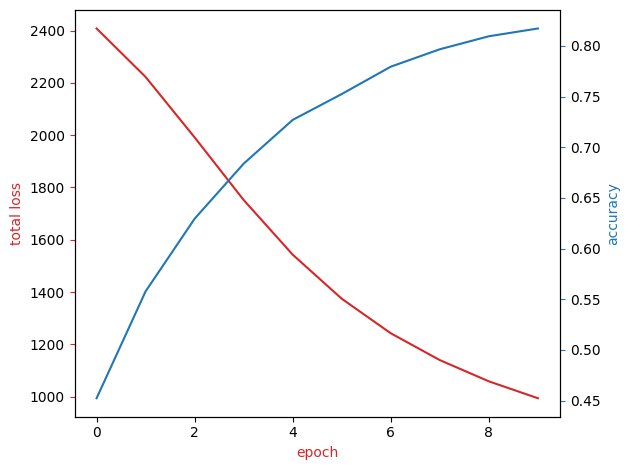

Evaluation on test:0.8125


In [5]:
LR=0.1

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)

EPOCHS = 10
cum_loss_list=[]
acc_epoch=[]
acc_old=0

for epoch in tqdm(range(1, EPOCHS + 1)):
    model.train()
    cum_loss=0
    for idx, (label, text, offsets) in enumerate(train_dataloader):
        optimizer.zero_grad()
        predicted_label = model(text, offsets)
        loss = criterion(predicted_label, label)
        loss.backward()
        # clips the gradients of a model's parameters, specifically by normalizing them if their total norm exceeds a certain threshold
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step() # updates model parameters based on bp
        cum_loss+=loss.item()

    cum_loss_list.append(cum_loss)
    accu_val = evaluate(valid_dataloader)
    acc_epoch.append(accu_val)

    if accu_val > acc_old:
      acc_old= accu_val
      torch.save(model.state_dict(), 'my_model.pth')

plot(cum_loss_list,acc_epoch)
print(f'Evaluation on test:{evaluate(test_dataloader)}')


In [6]:
model.load_state_dict(torch.load('my_model.pth'))
model.eval()


TextClassificationModel(
  (embedding): EmbeddingBag(95811, 64, mode='mean')
  (fc): Linear(in_features=64, out_features=4, bias=True)
)

In [7]:
new_articles = [
    "International talks have made significant headway with the signing of a climate accord that commits countries to reduce emissions by 40% over the next two decades. World leaders expressed optimism at the conclusion of the summit.",
    "In a stunning upset, the underdog team won the national title, beating the favorites in a match that featured an incredible comeback and a last-minute goal that sealed their victory in front of a record crowd.",
    "Market analysts are optimistic as the tech startup's stock prices soared after the announcement of their latest product, which promises to revolutionize how we interact with smart devices.",
    "A recent study published in a leading scientific journal suggests that a new drug has shown promise in the treatment of Alzheimer's disease, outperforming current leading medications in early clinical trials.",
    "Diplomatic relations have taken a positive turn with the recent peace talks that aim to end decades of conflict. The ceasefire agreement has been welcomed by the international community.",
    "Economic indicators show a sharp rebound in manufacturing, with the automobile industry leading the charge. Analysts predict this surge will result in significant job creation over the next year.",
    "Researchers at the university's astrophysics department have discovered a potentially habitable exoplanet. The planet, which lies in a nearby star system, has conditions that could support liquid water and, possibly, life.",
    "The sports world is in shock as a legendary player announces their retirement. Over an illustrious 20-year career, the athlete has amassed numerous records and is regarded as one of the greatest to ever play the game.",
    "A multinational corporation has announced a major investment in renewable energy. The initiative includes the construction of new wind farms and solar panels that will power hundreds of thousands of homes.",
    "Climate scientists warn that the melting of the polar ice caps has been accelerating at an alarming rate, raising sea levels and threatening coastal cities worldwide with increased flooding risks."
]

In [8]:
for i, article in enumerate(new_articles, start=1):
    prediction = predict(article, text_pipeline)
    print(f"Article {i} is classified as: {prediction}\n")

Article 1 is classified as: Sci/Tec

Article 2 is classified as: Sports

Article 3 is classified as: Sci/Tec

Article 4 is classified as: Business

Article 5 is classified as: Sci/Tec

Article 6 is classified as: Business

Article 7 is classified as: Sci/Tec

Article 8 is classified as: Sports

Article 9 is classified as: Sci/Tec

Article 10 is classified as: Sci/Tec



# Use case 02: N gram - language model:

In [2]:
from tqdm import tqdm
import numpy as np
import pandas as pd
from itertools import accumulate
import matplotlib.pyplot as plt
from torchtext.data.utils import get_tokenizer
import random

import torch
import torch.nn as nn

from torch.utils.data import DataLoader
import numpy as np
from torchtext.datasets import AG_NEWS
from IPython.display import Markdown as md
from tqdm import tqdm

from torchtext.vocab import build_vocab_from_iterator

from torch.utils.data.dataset import random_split
from torchtext.data.functional import to_map_style_dataset
from sklearn.manifold import TSNE
import plotly.graph_objs as go

from torchtext.data.utils import get_tokenizer

import torch.nn.functional as F
import torch.optim as optim



seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # For multi-GPU
random.seed(seed)
np.random.seed(seed)

# Ensure deterministic behavior
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

def plot(COST,ACC):
    fig, ax1 = plt.subplots()
    color = 'tab:red'
    ax1.plot(COST, color=color)
    ax1.set_xlabel('epoch', color=color)
    ax1.set_ylabel('total loss', color=color)
    ax1.tick_params(axis='y', color=color)
    
    ax2 = ax1.twinx()  
    color = 'tab:blue'
    ax2.set_ylabel('accuracy', color=color)  # you already handled the x-label with ax1
    ax2.plot(ACC, color=color)
    ax2.tick_params(axis='y', color=color)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    
    plt.show()

In [3]:
song= """We are no strangers to love
You know the rules and so do I
A full commitments what Im thinking of
You wouldnt get this from any other guy
I just wanna tell you how Im feeling
Gotta make you understand
Never gonna give you up
Never gonna let you down
Never gonna run around and desert you
Never gonna make you cry
Never gonna say goodbye
Never gonna tell a lie and hurt you
Weve known each other for so long
Your hearts been aching but youre too shy to say it
Inside we both know whats been going on
We know the game and were gonna play it
And if you ask me how Im feeling
Dont tell me youre too blind to see
Never gonna give you up
Never gonna let you down
Never gonna run around and desert you
Never gonna make you cry
Never gonna say goodbye
Never gonna tell a lie and hurt you
Never gonna give you up
Never gonna let you down
Never gonna run around and desert you
Never gonna make you cry
Never gonna say goodbye
Never gonna tell a lie and hurt you
Weve known each other for so long
Your hearts been aching but youre too shy to say it
Inside we both know whats been going on
We know the game and were gonna play it
I just wanna tell you how Im feeling
Gotta make you understand
Never gonna give you up
Never gonna let you down
Never gonna run around and desert you
Never gonna make you cry
Never gonna say goodbye
Never gonna tell a lie and hurt you
Never gonna give you up
Never gonna let you down
Never gonna run around and desert you
Never gonna make you cry
Never gonna say goodbye
Never gonna tell a lie and hurt you
Never gonna give you up
Never gonna let you down
Never gonna run around and desert you
Never gonna make you cry
Never gonna say goodbye
Never gonna tell a lie and hurt you"""

In [19]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

tokenizer = get_tokenizer("basic_english")
tokens=tokenizer(song)

# Create a vocabulary from text tokens

# tokenize the 'song' text using the provided tokenizer.
# The map function applies the tokenizer to each word in the 'song' after splitting it.
# The result is a list of tokens representing the words in the 'song'.
tokenized_song = map(tokenizer, song.split())

# Step 2: Vocabulary Building
# The build_vocab_from_iterator function constructs a vocabulary from the tokenized text.
# In this case, add a special token "<unk>" (unknown token) to handle out-of-vocabulary words.
vocab = build_vocab_from_iterator(tokenized_song, specials=["<unk>"])

# Step 3: Set Default Index
# Set the default index for the vocabulary to the index corresponding to the "<unk>" token.
# This ensures that any unknown tokens in the future will be mapped to this index.
vocab.set_default_index(vocab["<unk>"])

text_pipeline = lambda x: vocab(tokenizer(x))
index_to_token = vocab.get_itos()

# Embedding layer
embedding_dim=20
vocab_size=len(vocab)
embeddings = nn.Embedding(vocab_size, embedding_dim)


for n in range(2): 
    embedding=embeddings(torch.tensor(n))
    print("word",index_to_token[n])
    print("index",n)
    print( "embedding", embedding)
    print("embedding shape", embedding.shape)

CONTEXT_SIZE=2

ngrams = [([tokens[i - j - 1] for j in range(CONTEXT_SIZE)],tokens[i])
    for i in range(CONTEXT_SIZE, len(tokens))]

context, target=ngrams[0]
print("context",context,"target",target)
print("context index",vocab(context),"target index",vocab([target]))

linear = nn.Linear(embedding_dim*CONTEXT_SIZE,128)

my_embeddings=embeddings(torch.tensor(vocab(context)))
my_embeddings.shape # torch.Size([2, 20])

my_embeddings=my_embeddings.reshape(1,-1)
my_embeddings.shape # torch.Size([1, 40])

linear(my_embeddings)


word <unk>
index 0
embedding tensor([ 1.5885,  1.0206, -0.2543,  0.1221, -1.4104,  0.6432, -0.3016, -2.5028,
        -2.0694,  0.4159,  1.5611, -0.4200,  0.9186, -0.5002, -1.0488,  0.9092,
        -0.5898, -0.8523,  2.1167, -1.9215], grad_fn=<EmbeddingBackward0>)
embedding shape torch.Size([20])
word gonna
index 1
embedding tensor([ 0.8148,  0.9443,  0.0673, -0.3487, -0.2632, -0.8821, -0.1237,  0.7876,
        -0.0695, -0.0815,  1.4699, -0.1853,  1.3048,  0.9986, -0.1236, -1.2720,
        -1.0702,  0.0196,  0.4001, -0.2221], grad_fn=<EmbeddingBackward0>)
embedding shape torch.Size([20])
context ['are', 'we'] target no
context index [58, 21] target index [70]


tensor([[ 0.5010,  0.5552, -0.4585, -0.5177, -0.0057,  0.6070, -0.0620, -1.1615,
          0.6727, -0.1876,  0.1950, -0.8247, -0.0964, -0.4462, -0.0893,  1.6039,
         -0.4658, -0.0919,  0.5409,  0.6310, -0.4534,  0.2805,  0.3847,  0.5735,
          0.5999,  0.5510,  0.1103, -1.0212, -0.1141,  0.3863, -0.5503,  0.0456,
         -0.3017, -0.1401,  0.5002, -1.1824,  0.1464,  0.5902,  0.3715, -0.8163,
         -0.2462, -0.6680, -0.5548,  0.7420, -0.0523,  1.4603,  0.5466, -0.1697,
         -0.3334,  0.3607, -0.0233,  0.1327, -0.8002, -1.0465, -0.4885, -0.8374,
         -0.2504,  0.2329, -0.0443,  0.4768, -0.5849,  0.2142, -0.4428,  1.4495,
          0.3368,  0.7204,  0.3797,  1.5248, -0.8984,  0.1532, -0.1794,  0.7262,
          0.6259,  0.4609,  0.0870, -0.8166,  0.8170,  0.8147,  0.7422, -0.1725,
         -0.5079, -1.0523,  0.7160, -0.6957, -0.6426,  0.7530, -1.0512, -1.0147,
          0.7770,  1.1880,  0.0298,  0.0066,  0.1964,  0.6808,  0.2843,  0.7021,
          0.1100,  0.3576,  

## Batch function

In [20]:
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CONTEXT_SIZE=3
BATCH_SIZE=10
EMBEDDING_DIM = 10

def collate_batch(batch):
    batch_size=len(batch)
    context, target=[],[]
    for i in range(CONTEXT_SIZE,batch_size):
        target.append(vocab([batch[i]]))
        context.append(vocab([batch[i-j-1] for j in range(CONTEXT_SIZE)]))
    return   torch.tensor(context).to(device),  torch.tensor(target).to(device).reshape(-1)


Padding=BATCH_SIZE-len(tokens)%BATCH_SIZE #10 - (343%10) = 10 - 3 = 7
#343 + 7 = 350, this 350 can be make into 35 equal batches with each batch having 10.as_integer_ratio

# print(f'tokens:{tokens[0:5]} and len: {len(tokens)}')
# print(f'Padding: {Padding}')

tokens_pad=tokens+tokens[0:Padding]
# print(f'tokens[0:10]: {tokens[0:10]}')
# print(f'tokens_pad: {tokens_pad}')

dataloader = DataLoader(
     tokens_pad, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch
)

### check the contents of dataloader
context, target=next(iter(dataloader))
print("context",context,"target",target)

tokens:['we', 'are', 'no', 'strangers', 'to'] and len: 343
Padding: 7
tokens[0:10]: ['we', 'are', 'no', 'strangers', 'to', 'love', 'you', 'know', 'the', 'rules']
tokens_pad: ['we', 'are', 'no', 'strangers', 'to', 'love', 'you', 'know', 'the', 'rules', 'and', 'so', 'do', 'i', 'a', 'full', 'commitments', 'what', 'im', 'thinking', 'of', 'you', 'wouldnt', 'get', 'this', 'from', 'any', 'other', 'guy', 'i', 'just', 'wanna', 'tell', 'you', 'how', 'im', 'feeling', 'gotta', 'make', 'you', 'understand', 'never', 'gonna', 'give', 'you', 'up', 'never', 'gonna', 'let', 'you', 'down', 'never', 'gonna', 'run', 'around', 'and', 'desert', 'you', 'never', 'gonna', 'make', 'you', 'cry', 'never', 'gonna', 'say', 'goodbye', 'never', 'gonna', 'tell', 'a', 'lie', 'and', 'hurt', 'you', 'weve', 'known', 'each', 'other', 'for', 'so', 'long', 'your', 'hearts', 'been', 'aching', 'but', 'youre', 'too', 'shy', 'to', 'say', 'it', 'inside', 'we', 'both', 'know', 'whats', 'been', 'going', 'on', 'we', 'know', 'the', 'g

## NGramLanguageModeler

In [26]:
class NGramLanguageModeler(nn.Module):

    def __init__(self, vocab_size, embedding_dim, context_size):
        super(NGramLanguageModeler, self).__init__()
        self.context_size=context_size
        self.embedding_dim=embedding_dim
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(context_size * embedding_dim, 128)
        self.linear2 = nn.Linear(128, vocab_size)

    def forward(self, inputs):
        embeds = self.embeddings(inputs)
        embeds=torch.reshape( embeds, (-1,self.context_size * self.embedding_dim))
        out = F.relu(self.linear1(embeds))
        out = self.linear2(out)
        return out

def write_song(model,number_of_words=100):
    my_song=""
    for i in range(number_of_words):
        with torch.no_grad():
            context=torch.tensor(vocab([tokens[i-j-1] for j in range(CONTEXT_SIZE)])).to(device)
            word_inx=torch.argmax(model(context))
            my_song+=" "+index_to_token[word_inx.detach().item()]
    return my_song


model = NGramLanguageModeler(len(vocab), EMBEDDING_DIM, CONTEXT_SIZE).to(device)
print("parameter sizes",len(vocab), EMBEDDING_DIM, CONTEXT_SIZE)


print(write_song(model))

context, target=next(iter(dataloader))
out=model(context)
print(f'output: {out}, out shape: {out.shape}')

predicted_index =torch.argmax(out,1)
predicted_index

[index_to_token[i.item()] for i in  predicted_index]


# DIMENTIONS of N-GRAM MODEL: for 4 gram model:
#### vs = 9, CS = 3, E = 10,HU = 128, BS (batch_samples) = 7
#    EM   =>  Input    =>   Layer1   =>  Layer2   => Output_layer
# (79,10) => (1, 3*10) => (3*10,128) => (128, vs) => (79, 7)
# (vs,E) => (1, CS*E) => (CS*E,HU) => (HU, vs) => (vs, BS)

parameter sizes 79 10 3
 game guy any of any play <unk> understand any do to guy rules any guy a any any any any other are dont you any how any <unk> play on lie how any inside give you so but guy understand inside any inside any any understand up you <unk> any cry you any <unk> <unk> inside understand any commitments you any <unk> any any strangers understand any any you give game give guy me <unk> game any any understand understand on your understand understand lie both understand know any for on if any any understand any but other game down
output: tensor([[ 1.3697e-01,  1.7976e-03,  2.2174e-01, -3.5655e-01, -3.1759e-02,
          2.5704e-01, -2.7848e-01, -5.0284e-02,  1.8520e-02, -1.7734e-01,
         -3.5147e-02, -2.6520e-01,  1.6387e-02, -1.8806e-01, -2.6350e-01,
         -2.0636e-03, -1.6634e-01,  1.0712e-02,  2.4546e-02,  7.2651e-02,
          4.9265e-02, -2.7145e-01, -3.8892e-01, -5.1127e-01, -5.1061e-01,
         -2.6241e-02, -2.1371e-01,  1.0235e-01,  2.8112e-02,  1.5743e-01

['of', 'any', 'play', '<unk>', 'understand', 'any', 'do']

# Training

In [12]:
criterion = torch.nn.CrossEntropyLoss()
def train(dataloader, model, number_of_epochs=100, show=10):
    """
    Args:
        dataloader (DataLoader): DataLoader containing training data.
        model (nn.Module): Neural network model to be trained.
        number_of_epochs (int, optional): Number of epochs for training. Default is 100.
        show (int, optional): Interval for displaying progress. Default is 10.

    Returns:
        list: List containing loss values for each epoch.
    """

    MY_LOSS = []  # List to store loss values for each epoch

    # Iterate over the specified number of epochs
    for epoch in tqdm(range(number_of_epochs)):
        total_loss = 0  # Initialize total loss for the current epoch
        my_song = ""    # Initialize a string to store the generated song

        # Iterate over batches in the dataloader
        for context, target in dataloader:
            model.zero_grad()          # Zero the gradients to avoid accumulation
            predicted = model(context)  # Forward pass through the model to get predictions
            loss = criterion(predicted, target.reshape(-1))  # Calculate the loss
            total_loss += loss.item()   # Accumulate the loss

            loss.backward()    # Backpropagation to compute gradients
            optimizer.step()   # Update model parameters using the optimizer

        # Display progress and generate song at specified intervals
        if epoch % show == 0:
            my_song += write_song(model)  # Generate song using the model

            print("Generated Song:")
            print("\n")
            print(my_song)

        MY_LOSS.append(total_loss/len(dataloader))  # Append the total loss for the epoch to MY_LOSS list

    return MY_LOSS  # Return the list of  mean loss values for each epoch

In [15]:
my_loss_list=[]
# Define the context size for the n-gram model
CONTEXT_SIZE = 2

# Create an instance of the NGramLanguageModeler class with specified parameters
model_2 = NGramLanguageModeler(len(vocab), EMBEDDING_DIM, CONTEXT_SIZE).to(device)

# Define the optimizer for training the model, using stochastic gradient descent (SGD)
optimizer = optim.SGD(model_2.parameters(), lr=0.01)

# Set up a learning rate scheduler using StepLR to adjust the learning rate during training
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1.0, gamma=0.1)

In [ ]:
my_loss=train(dataloader,model_2)

save_path = '2gram.pth'
torch.save(model_2.state_dict(), save_path)
my_loss_list.append(my_loss)

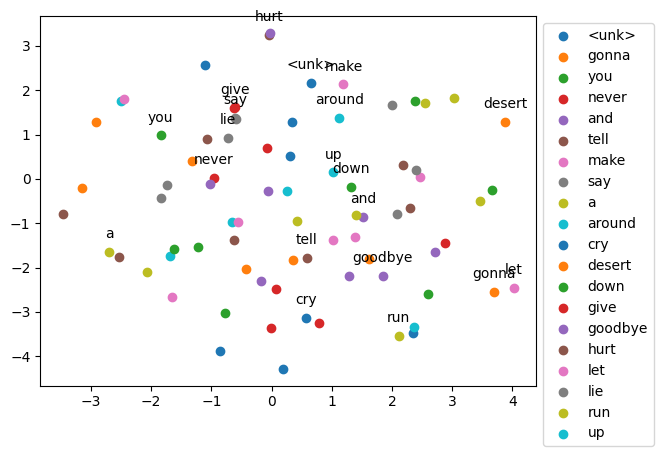

In [16]:
X = model_2.embeddings.weight.cpu().detach().numpy()
tsne = TSNE(n_components=2, random_state=42)
X_2d = tsne.fit_transform(X)

labels = []

for j in range(len(X_2d)):
    if j < 20:
        plt.scatter(X_2d[j, 0], X_2d[j, 1], label=index_to_token[j])
        labels.append(index_to_token[j])
        # Add words as annotations
        plt.annotate(index_to_token[j],
                     (X_2d[j, 0], X_2d[j, 1]),
                     textcoords="offset points",
                     xytext=(0, 10),
                     ha='center')
    else:
        plt.scatter(X_2d[j, 0], X_2d[j, 1])

plt.legend(labels, loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [17]:
CONTEXT_SIZE=4
model_4 = NGramLanguageModeler(len(vocab), EMBEDDING_DIM, CONTEXT_SIZE).to(device)
optimizer = optim.SGD(model_4.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
my_loss=train(dataloader,model_4 )

save_path = '4gram.pth'
torch.save(model_4.state_dict(), save_path)

my_loss_list.append(my_loss)

  7%|▋         | 7/100 [00:00<00:02, 34.17it/s]

Generated Song:


 known you known and it on let desert it it im desert other gonna no never commitments commitments commitments we it gonna let it were it understand commitments gonna you guy commitments it you hurt it desert it let gonna known it just were desert other commitments gonna were known on commitments gonna were it dont it other a it were it known commitments gonna were known it how both you full wanna desert you known gonna commitments it and gonna hurt gonna no let you were known never you commitments commitments a it known it no it it gonna


 18%|█▊        | 18/100 [00:00<00:01, 43.81it/s]

Generated Song:


 never gonna you gonna you you you never never gonna never you never gonna gonna you never never never gonna never gonna never you never never gonna you gonna you never gonna you gonna never never gonna you you you you never gonna say you never never gonna let you never never gonna say you and never you never gonna make you never never gonna say you never gonna tell you and never never you never gonna never gonna gonna you never gonna gonna you you and you never never you never you you never you gonna never never gonna


 31%|███       | 31/100 [00:00<00:01, 51.02it/s]

Generated Song:


 never never never gonna and you you never never gonna never you you never gonna you never never im gonna never gonna tell you never never gonna other gonna and never gonna tell gonna down im feeling gonna make you you never gonna say you up never gonna let you down never gonna make around and desert you never gonna make you and never gonna say goodbye never gonna tell a lie and desert you never gonna never gonna gonna you never gonna gonna make you and you never never you never you you never never know never never gonna
Generated Song:


 never never never gonna to love you never never gonna never you never never a make never and im gonna never gonna tell you never never gonna other gonna and never gonna tell a how im feeling gotta make you you never gonna let you up never gonna let you down never gonna make around and desert you never gonna make you down never gonna say goodbye never gonna tell a lie and hurt you never known each other for you never never gonna make

 49%|████▉     | 49/100 [00:01<00:00, 53.20it/s]

Generated Song:


 never never know gonna to love you never never gonna never you never never a make commitments and im gonna never gonna tell you never never gonna other gonna and hurt gonna tell a how im feeling gotta make you you never gonna let you up never gonna let you down never gonna let around and desert you never gonna make you cry never gonna say goodbye never gonna tell a lie and hurt you never known each other for you never never gonna make aching but youre too shy to and you you how both know whats been going
Generated Song:


 never are know strangers to love you know never never never were never never a make commitments and im thinking been gonna tell youre this never gonna other guy i hurt gonna tell a how im feeling gotta make you cry never gonna let you up never gonna let you down never gonna run around and desert you never gonna make you cry never gonna say goodbye never gonna tell a lie and hurt you never known each other for so never never gonna been aching but yo

 68%|██████▊   | 68/100 [00:01<00:00, 58.79it/s]

Generated Song:


 never are know strangers to love you know never rules never were never never a full commitments what im thinking been gonna tell youre this from any other guy i hurt gonna tell a how im feeling gotta make you cry never gonna let you up never gonna let you down never gonna run around and desert you never gonna make you cry never gonna say goodbye never gonna tell a lie and hurt you never known each other for so never never gonna been aching but youre too shy to to you gonna we both know whats been going
Generated Song:


 never are no strangers to love you know the rules say were and never a full commitments what im thinking been gonna tell youre this from any other guy i hurt gonna tell a how im feeling gotta make you cry never gonna let you up never gonna let you down never gonna run around and desert you never gonna make you cry never gonna say goodbye never gonna tell a lie and hurt you never known each other for so never never gonna been aching but youre too shy 

 93%|█████████▎| 93/100 [00:01<00:00, 58.76it/s]

Generated Song:


 never are no strangers to love you know the rules say were and never a full commitments what im thinking been gonna tell youre this from any other guy i hurt gonna tell a how im feeling gotta make you cry never gonna let you up never gonna let you down never gonna run around and desert you never gonna make you cry never gonna say goodbye never gonna tell a lie and hurt you never known each other for so never never gonna been aching but youre too shy to to you gonna we both know whats been going
Generated Song:


 never are no strangers to love you know the rules say were and never a full commitments what im thinking been gonna tell the this from any other guy i hurt gonna tell a how im feeling gotta make you cry never gonna run you up never gonna let you down never gonna run around and desert you never gonna make you cry never gonna say goodbye never gonna tell a lie and hurt you never known each other for so never never gonna been aching but youre too shy to see you

100%|██████████| 100/100 [00:01<00:00, 53.79it/s]


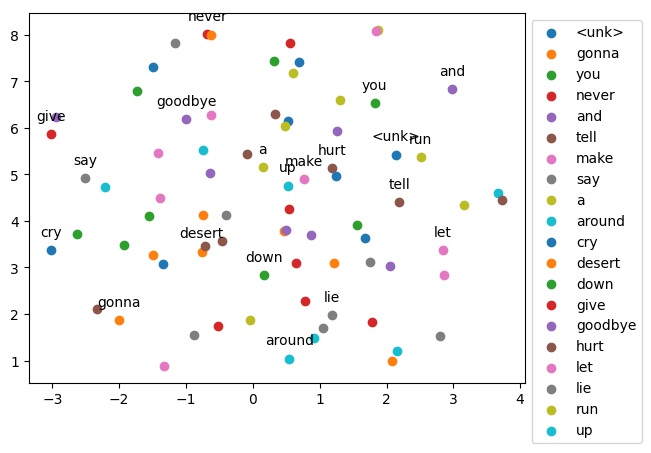

In [19]:
X = model_4.embeddings.weight.cpu().detach().numpy()
tsne = TSNE(n_components=2, random_state=42)
X_2d = tsne.fit_transform(X)

labels = []

for j in range(len(X_2d)):
    if j < 20:
        plt.scatter(X_2d[j, 0], X_2d[j, 1], label=index_to_token[j])
        labels.append(index_to_token[j])
        # Add words as annotations
        plt.annotate(index_to_token[j],
                     (X_2d[j, 0], X_2d[j, 1]),
                     textcoords="offset points",
                     xytext=(0, 10),
                     ha='center')
    else:
        plt.scatter(X_2d[j, 0], X_2d[j, 1])

plt.legend(labels, loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

  7%|▋         | 7/100 [00:00<00:01, 63.13it/s]

Generated Song:


 never never of you going up but you you you hurt lie up hurt you feeling inside you never up you gonna you you hearts never you you each never and you going you too you gonna hurt feeling never you dont been and but you it gonna aching you you gonna gonna it you were gonna dont you gonna of gonna for you gonna you you up gonna to you you aching hurt you never you and you you you inside you you you going around you too been for you hearts you for you wanna you of you
Generated Song:


 never never gonna you for you you never gonna you you going you you you never you you you thinking you you never never make make you you you you you you gonna you tell you gonna gonna make you you you gonna tell you tell you gonna let you down never gonna let around and you gonna never gonna make you make never gonna let you down gonna tell a lie never hurt you never never make you for so you you you you going around you too shy make you you never you you never you been going


 27%|██▋       | 27/100 [00:00<00:01, 59.51it/s]

Generated Song:


 never never gonna you for love you never the rules you going you you you i you make im thinking shy you never never make make for you guy i you you a you tell you i gonna make you you you gonna say you up never gonna let you down never gonna run around and you gonna never gonna make you up never gonna say you down gonna tell a lie never hurt you never it it other for so around you you gonna going around you too shy to never you never you you love you been going
Generated Song:


 never never gonna other up love you never the rules you going you you you i you make im thinking love you never never make make for you guy i you you a you too gonna to gonna make you you you gonna say you up never gonna let you down never gonna run around and you gonna never gonna make you up never gonna say you down gonna tell a lie never hurt you never the it other for so give and you gonna going around you too shy to never make never give you love you been going


 48%|████▊     | 48/100 [00:00<00:00, 62.07it/s]

Generated Song:


 never never gonna other up love you never the rules you going you you you i you make im thinking love you never never make make for you guy i you you a you too gonna to gonna make you you you gonna say you up never gonna let you down never gonna run around and you gonna never gonna make you up never gonna say you down gonna tell a lie never hurt you never the the other for so give and you gonna going around you too shy to never make never give you love you been going
Generated Song:


 never never gonna other up love you never the rules you going you you it i you to im thinking love you never never make make for you guy i you you a you too gonna to gonna make you you you gonna say you up never gonna let you down never gonna run around and you gonna never gonna make you up never gonna say you down gonna tell a lie never hurt you never the the other for so give and you gonna been around you too shy to never make never give you love you been going


 68%|██████▊   | 68/100 [00:01<00:00, 60.09it/s]

Generated Song:


 never never gonna other up love you never the rules you going you you it i you to im thinking love you never never make make for you guy i you you a you too gonna to gonna make you you you gonna say you up never gonna let you down never gonna run around and you gonna never gonna make you up never gonna say you down gonna tell a lie never hurt you never the the other for so im and you gonna been around you too shy to never make never give you love you been going
Generated Song:


 never never gonna other up love you never the rules you going you you it i you to im thinking love you never never make make for you guy i you you a you too gonna to gonna make you you you gonna say you up never gonna let you down never gonna run around and you gonna never gonna make you up never gonna say you down gonna tell a lie never hurt you never the the other for so im and you gonna been around you too shy to never make never give you love you been going


 89%|████████▉ | 89/100 [00:01<00:00, 59.90it/s]

Generated Song:


 never never gonna other up love you never the rules you going you you it i you to im thinking thinking you never never make make for you guy i you you a dont too gonna to gonna make you you you gonna say you up never gonna let you down never gonna run around and you gonna never gonna make you up never gonna say you down gonna tell a lie never hurt you never the the other for so im and you gonna been around you too shy to never make never give you love you been going
Generated Song:


 never the gonna other up love you never the rules you going you you it i you to im thinking thinking you never never make make for you guy i you you to dont too gonna to gonna make you you you gonna say you up never gonna let you down never gonna run around and you gonna never gonna make you up never gonna say you down gonna tell a lie never hurt you never the the other for so im and you gonna been around you too shy to never make never give you love you been going


100%|██████████| 100/100 [00:01<00:00, 59.60it/s]


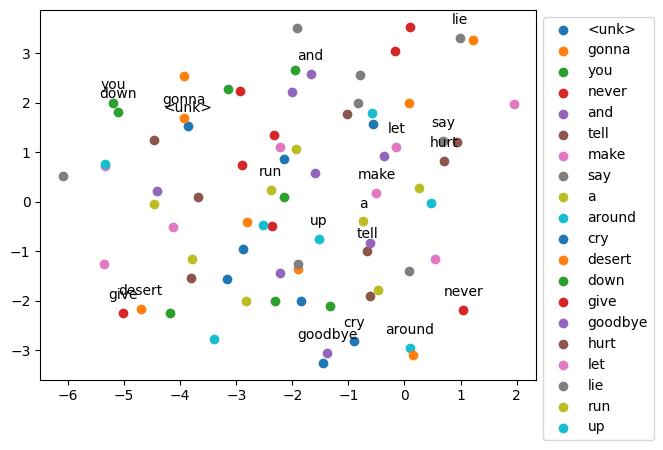

In [20]:
CONTEXT_SIZE=8
model_8 = NGramLanguageModeler(len(vocab), EMBEDDING_DIM, CONTEXT_SIZE).to(device)
optimizer = optim.SGD(model_8.parameters(), lr=0.01)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
my_loss=train(dataloader,model_8)

save_path = '8gram.pth'
torch.save(model_8.state_dict(), save_path)

my_loss_list.append(my_loss)

X = model_8.embeddings.weight.cpu().detach().numpy()
tsne = TSNE(n_components=2, random_state=42)
X_2d = tsne.fit_transform(X)

labels = []

for j in range(len(X_2d)):
    if j < 20:
        plt.scatter(X_2d[j, 0], X_2d[j, 1], label=index_to_token[j])
        labels.append(index_to_token[j])
        # Add words as annotations
        plt.annotate(index_to_token[j],
                     (X_2d[j, 0], X_2d[j, 1]),
                     textcoords="offset points",
                     xytext=(0, 10),
                     ha='center')
    else:
        plt.scatter(X_2d[j, 0], X_2d[j, 1])

plt.legend(labels, loc='upper left', bbox_to_anchor=(1, 1))
plt.show()


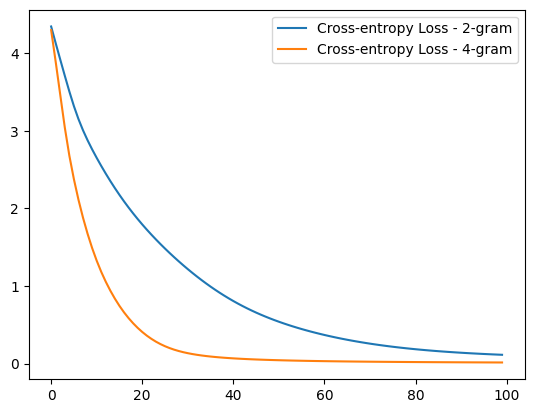

In [21]:
for (my_loss, model_name)in zip(my_loss_list,["2-gram","4-gram","8-gram"]):
    plt.plot(my_loss,label="Cross-entropy Loss - {}".format(model_name))
    plt.legend()

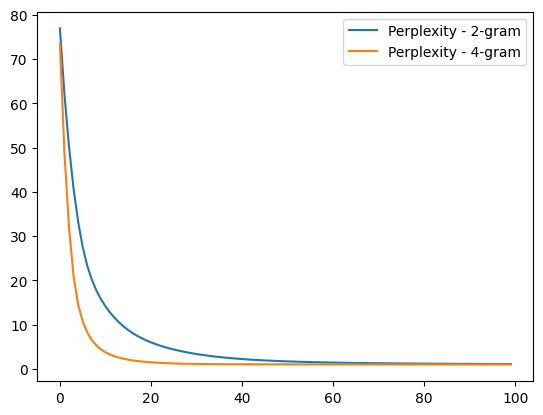

In [22]:
for (my_loss, model_name)in zip(my_loss_list,["2-gram","4-gram","8-gram"]):
    # Calculate perplexity using the loss
    perplexity = np.exp(my_loss)
    plt.plot(perplexity,label="Perplexity - {}".format(model_name))
    plt.legend()